In [1]:
import preprocessing
import pandas as pd
import numpy as np
import importlib
from english_contractions import ENGLISH_CONTRACTIONS
import merging_dataframes
import word_pronunciation_predictibility
import celex_files
from celex_files import read_celex_file, get_syl_counts
import torch
import os
#import librosa
from scipy.io import wavfile
from pyannote.audio.utils.signal import Peak
from g2p_en import G2p # https://github.com/Kyubyong/g2p
import syllables
import time
import timeit
import csv

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
#pip install git+https://github.com/pyannote/pyannote-audio.git@develop
#pip install pyAudioAnalysis

In [2]:
BASE = '/mnt/Restricted/Corpora/RedHen'
DATA_FOLDER = os.path.join(BASE, 'original')
DF_SOURCE_PATH = os.path.join(BASE, '2016_all_words_no_audio.pickle')
#DF_HOMEOHONES_PATH = os.path.join(BASE, 'homophone_analysis_scripts/2016_all_words_no_audio_preprocessed.csv')
DF_HOMOGRAPHS_PATH = os.path.join(BASE, 'homophone_analysis_scripts/2016_all_words_no_audio_homographs_preprocessed.csv')
celex_dict_file = "/mnt/shared/corpora/Celex/english/epw/epw.cd"

#STRETCHES_PATH = BASE + '/homophone_analysis_scripts'
STRETCHES_PATH = '10_sec_stretches'#'/mnt/shared/people/elnaz/homophones/10sec_stretch/'

NS = '<non-speech>'

In [3]:
df_source = pd.read_pickle(DF_SOURCE_PATH)
df_hom = pd.read_csv(DF_HOMOGRAPHS_PATH, index_col = "Unnamed: 0")
celex_dict = read_celex_file()
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
peak = Peak(alpha=0.2, min_duration=0.20, log_scale=True)

Using cache found in /home/paul/.cache/torch/hub/pyannote_pyannote-audio_master


In [4]:
df_hom

,source_file,word,start,end,duration,label_type,mp4_error,aac_error,aac2wav_error,eafgz_error,...,gentle_prev_word,gentle_next_word,gentle_end_of_sentence,gentle_start_of_sentence,gentle_preceding_marker,gentle_subsequent_marker,gentle_merging,gentle_index,m_score,SylCnt
0,2016-01-01_0100_US_KNBC_Channel_4_News,fire,21.75,22.110000,0.36,high-confidence,no-error,no-error,no-error,no-error,...,this,broke,False,False,False,False,high-confidence,81.0,0.863,2
1,2016-01-01_0100_US_KNBC_Channel_4_News,fire,46.35,46.879999,0.53,high-confidence,no-error,no-error,no-error,no-error,...,the,the,True,False,False,True,high-confidence,158.0,0.863,2
2,2016-01-01_0100_US_KNBC_Channel_4_News,fire,48.07,48.290000,0.22,high-confidence,no-error,no-error,no-error,no-error,...,the,started,False,False,False,False,high-confidence,161.0,0.863,2
3,2016-01-01_0100_US_KNBC_Channel_4_News,fire,68.99,69.380000,0.39,high-confidence,no-error,no-error,no-error,no-error,...,hotel,nearby,False,False,False,False,high-confidence,235.0,0.863,2
4,2016-01-01_0100_US_KNBC_Channel_4_News,fire,99.12,99.370000,0.25,high-confidence,no-error,no-error,no-error,no-error,...,caught,is,False,False,False,False,high-confidence,310.0,0.863,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294813,2016-12-29_1400_US_CNN_CNN_Newsroom_With_Carol...,dress,182.11,182.440000,0.33,high-confidence,no-error,no-error,no-error,no-error,...,subway,at,False,False,False,False,high-confidence,21452902.0,1.000,1
294814,2016-12-29_1500_US_CNN_CNN_Newsroom_With_Carol...,dress,1350.66,1351.050000,0.39,high-confidence,no-error,no-error,no-error,no-error,...,eccentric,and,False,False,False,False,high-confidence,21465305.0,1.000,1
294815,2016-12-31_0230_US_KCBS_CBS_Evening_News_With_...,dress,1550.44,1550.730000,0.29,high-confidence,no-error,no-error,no-error,no-error,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1
294816,2016-12-31_1300_US_MSNBC_MSNBC_Live,dress,674.31,674.609999,0.30,high-confidence,no-error,no-error,no-error,no-error,...,at,rehearsal,False,False,False,False,high-confidence,21657916.0,1.000,1


In [5]:
def get_file_path(file_name, file_extension):
    base_name = os.path.basename(file_name)
    year, month, day = base_name[:10].split('-')
    file_path = f'{DATA_FOLDER}/{year}/{year}-{month}/{year}-{month}-{day}/{base_name}{file_extension}'
    return file_path

def get_prev_context(row):
    source_file, word, start, end = row[['source_file', 'word', 'start', 'end']]
    prev_context = df_source.loc[(df_source.source_file == source_file) &
                                 (start - df_source.start >= 0) & 
                                 (start - df_source.start <= 10) & 
                                 (start - df_source.end >= 0) &
                                 (start - df_source.end <= 10)]
    interruptions = prev_context[(prev_context.word == NS) &
                                 (prev_context.duration >= 0.4)] 
    if interruptions.empty:
        return prev_context[prev_context.word != NS]
    return prev_context[prev_context.start >= interruptions.iloc[-1].end]

def get_next_context(row):
    source_file, word, start, end = row[['source_file', 'word', 'start', 'end']]
    next_context = df_source.loc[(df_source.source_file == source_file) &
                                 (df_source.end - end >= 0) & 
                                 (df_source.end - end <= 10) & 
                                 (df_source.start - end >= 0) &
                                 (df_source.start - end <= 10)]
    interruptions = next_context[(next_context.word == NS) &
                                 (next_context.duration >= 0.4)] 
    if interruptions.empty:
        return next_context[next_context.word != NS]
    return next_context[next_context.end <= interruptions.iloc[0].start]


def get_context(source_file, word, start, end, df_source_file): 
    

    # next context
    c_end = df_source_file.end - end 
    c_start = df_source_file.start - end
    c1 = (c_end >= 0).values & (c_end<=10).values
    c2 = (c_start >= 0).values & (c_start <= 10).values
    c = c1 & c2
    
    next_context = df_source_file[c]
    
    c = (next_context.word == NS).values & (next_context.duration >= 0.4).values
    interruptions_next = next_context[c] 
    
    # prev context
    c_end = start - df_source_file.end
    c_start = start - df_source_file.start
    c1 = (c_start >=0).values & (c_start <= 10).values
    c2 = (c_end >= 0).values & (c_end<=10).values
    c = c1 & c2
    
    
    prev_context = df_source_file[c]
    c = (prev_context.word == NS).values & (prev_context.duration >= 0.4).values
    interruptions_prev = prev_context[c] 
    
    if interruptions_prev.empty:
        c = prev_context.word != NS
        prev_context = prev_context[c]
    else:
        c = prev_context.start >= interruptions_prev.iloc[-1].end
        prev_context = prev_context[c]
    if interruptions_next.empty:
        c = next_context.word != NS
        next_context = next_context[c]
    else:
        c = next_context.end <= interruptions_next.iloc[0].start
        next_context = next_context[c]
        
    return prev_context, next_context



""" librosa 
def get_audio_segments(row, audio, sr):
    prev_context=get_prev_context(row)
    next_context=get_next_context(row)
    #audio_file = get_file_path(row.source_file, '.wav')
    #audio, sr = librosa.load(audio_file, sr=None)
    # word
    
    word = row.word
    
    # prev
    if len(prev_context) > 0:
        onset = librosa.frames_to_samples(librosa.time_to_frames(prev_context.start.iloc[0], sr))
    else:
        onset = librosa.frames_to_samples(librosa.time_to_frames(row.start, sr))
    #offset = librosa.frames_to_samples(librosa.time_to_frames(prev_context.end.iloc[-1], sr))
    offset = librosa.frames_to_samples(librosa.time_to_frames(row.end, sr))
    audio_seg = audio[onset:offset]
    librosa.output.write_wav(os.path.join(STRETCHES_PATH, df_hom.source_file.iloc[0]+f'_{word}_prev.wav'), audio_seg, sr)
    
    # next
    # onset = librosa.frames_to_samples(librosa.time_to_frames(next_context.start.iloc[0], sr))
    onset = librosa.frames_to_samples(librosa.time_to_frames(row.start, sr))
    if len(next_context) > 0:
        offset = librosa.frames_to_samples(librosa.time_to_frames(next_context.end.iloc[-1], sr))
    else:
        offset = librosa.frames_to_samples(librosa.time_to_frames(row.end, sr))

    audio_seg = audio[onset:offset]
    librosa.output.write_wav(os.path.join(STRETCHES_PATH, df_hom.source_file.iloc[0]+f'_{word}_next.wav'), audio_seg, sr)
    
    prev_context= prev_context.append(row[['source_file', 'word', 'start', 'end', 'duration', 'label_type',
       'mp4_error', 'aac_error', 'aac2wav_error', 'eafgz_error', 'seg_error']])
    next_context = next_context.append(row[['source_file', 'word', 'start', 'end', 'duration', 'label_type',
       'mp4_error', 'aac_error', 'aac2wav_error', 'eafgz_error', 'seg_error']])
    
    return prev_context, os.path.join(STRETCHES_PATH, df_hom.source_file.iloc[0]+f'_{word}_prev.wav'), next_context, os.path.join(STRETCHES_PATH, df_hom.source_file.iloc[0]+f'_{word}_next.wav')
"""

def extract_interval_wave(audio, sr, start, end):
    """ 
    Returns wave data from start (seconds) to end (seconds) 
    
    Parameters
    ----------
    audio: wave data.
    sr: sampling rate of the audio.
    start: in seconds
    end: in seconds
    """
    start *= sr
    end *= sr
    return audio[np.int(start):np.int(end)]

def get_audio_segments(index,source_file, word, start, end, duration, df_source_file, audio, sr, save_files = True): # idx,source_file, word, start, end, duration / row
    #print(index)
    #prev_context=get_prev_context(row)
    #next_context=get_next_context(row)
    #prev_context, next_context = get_context(row,df_source_file)
    prev_context, next_context = get_context(source_file, word, start, end,df_source_file)

    #audio_file = get_file_path(row.source_file, '.wav')
    #audio, sr = librosa.load(audio_file, sr=None)
    # word
    
    #word = row.word
    
    # prev
    if len(prev_context) > 0:
        onset = prev_context.start.iloc[0]
    else:
        #onset = row.start
        onset = start
    
    #offset = row.end 
    offset = end
    
    if save_files:
        audio_seg = extract_interval_wave(audio, sr,onset,offset)
        #print("Save files temporarily ")
        wavfile.write(os.path.join(STRETCHES_PATH, source_file+'_%s_prev%s.wav' % (word,index)), sr, audio_seg)
        prev_file = os.path.join(STRETCHES_PATH, source_file+'_%s_prev%s.wav' % (word,index))
        #print(index, prev_file)
        #print(index, audio_seg, prev_file)
    else:
        prev_file = None
    
    # next
    #onset = row.start 
    if len(next_context) > 0:
        offset = next_context.end.iloc[-1]
    else:
        offset = end 

    
    if save_files:
        audio_seg = extract_interval_wave(audio, sr,onset,offset)
        wavfile.write(os.path.join(STRETCHES_PATH, source_file+'_%s_next%s.wav' % (word,index)), sr, audio_seg)
        next_file = os.path.join(STRETCHES_PATH, source_file+'_%s_next%s.wav' % (word,index))
        #print(index, next_file)
    else:
        next_file = None
    
    
    #prev_context= prev_context.append(row[['source_file', 'word', 'start', 'end', 'duration', 'label_type',
    #   'mp4_error', 'aac_error', 'aac2wav_error', 'eafgz_error', 'seg_error']])
    #print(prev_context)
    
    prev_context.loc[len(prev_context)] = [source_file, word, start, end, duration, None, None, None, None, None, None, None]
    
    
    #next_context = next_context.append(row[['source_file', 'word', 'start', 'end', 'duration', 'label_type',
    #   'mp4_error', 'aac_error', 'aac2wav_error', 'eafgz_error', 'seg_error']])
    
    next_context.loc[len(next_context)] = [source_file, word, start, end, duration, None, None, None, None, None, None, None]
    
    #return prev_context, prev_file, next_context, next_file
    #return pd.Series([prev_context, prev_file, next_context, next_file], ['prev_context', 'prev_file', 'next_context', 'next_file'])
    return [prev_context, prev_file, next_context, next_file]


def detect_speaker_changes(speech_dection_model,peak_detection_model,file):
    test_file = {'audio': file}
    print(file)
    try:
        speech_change_detection = speech_dection_model(test_file)
        partition = peak_detection_model.apply(speech_change_detection, dimension=1)
    except Exception as e:
        print(e)
        print("No partition found!")
        partition = None
    
    try:
        os.remove(file)
    except Exception as e:
        print(e)
    return partition
"""
def calculate_syl_counts(context):
    #missing_words = []
    #missing_words_estimate = []
    SylCnts = []
    for i,row in context.iterrows():
        if celex_dict[celex_dict.Word == row.word.lower()].PhonStrsDISC.empty:
            SyllCnt = syllables.estimate(row.word)
            #missing_words.append(row.word)
            #missing_words_estimate.append(SyllCnt)
        else:
            PhonStrsDisc = celex_dict[celex_dict.Word == row.word.lower()].PhonStrsDISC.iloc[0]
            SyllCnt = PhonStrsDisc.count("-")+1
        SylCnts.append(SyllCnt)

    return SylCnts
"""

def calculate_syl_counts(context): # words
    words_in_celex = context.word.str.lower().isin(celex_dict.Word.values).values
    #words_in_celex = np.isin([word.lower() for word in words], celex_dict.Word.values)
    words_not_in_celex = np.invert(words_in_celex) 
    
    """
    if np.sum(words_not_in_celex)>0:
        SylCnts_estimate = np.vectorize(syllables.estimate)(words[words_not_in_celex])
    else:
        SylCnts_estimate = []
    """
    SylCnts_estimate = context.word[words_not_in_celex].apply(syllables.estimate)
    #SylCnts_estimate = list(map(syllables.estimate,context.word[words_not_in_celex].values))
    
    #celex_words = np.isin(celex_dict.Word.values, words[words_in_celex])
    #SylCnts_celex = celex_dict[["PhonStrsDISC","Word"]][celex_words].drop_duplicates()
    
    SylCnts_celex = context[words_in_celex].merge(celex_dict[["PhonStrsDISC","Word"]],how="left",left_on = "word", right_on="Word").drop_duplicates()
    return np.sum(SylCnts_estimate) + np.sum(SylCnts_celex.PhonStrsDISC.str.count("-")+1)
    
"""
def calculate_contextual_speaking_rate(row, prev_context,prev_partition,next_context,next_partition, use_heuristic = False):
    source_file, word, start, end = row[['source_file', 'word', 'start', 'end']]
    
    if use_heuristic:
        valid_prev_context = prev_context
        valid_next_context = next_context
        
    else:
        if prev_partition is None:
            speaker_onset = start
        else:
            speaker_onset = prev_partition[-1].end - prev_partition[-1].start
        if next_partition is None:
            speaker_offset = end
        else:
            speaker_offset = next_partition[0].end - next_partition[0].start

        c_start = start - prev_context.start
        valid_prev_c = (c_start >= 0).values & (c_start <= speaker_onset).values
        valid_prev_context = prev_context[valid_prev_c]

        
        c_end = next_context.end - end
        valid_next_c = (c_end >= 0).values & (c_end <= speaker_offset).values
        valid_next_context = next_context[valid_next_c]
    
    #syl_counts_prev = [syllables.estimate(word) for word in valid_prev_context.word]#get_syl_counts(valid_prev_context).SylCnt
    #syl_counts_next = [syllables.estimate(word) for word in valid_next_context.word]#get_syl_counts(valid_next_context).SylCnt
    syl_counts_prev = calculate_syl_counts(valid_prev_context)
    syl_counts_next = calculate_syl_counts(valid_next_context)
    
    prev_stretch_duration = np.sort(valid_prev_context.end)[-1] - np.sort(valid_prev_context.start)[0]
    next_stretch_duration = np.sort(valid_next_context.end)[-1] - np.sort(valid_next_context.start)[0]
    
    
    speaking_rate_prev = syl_counts_prev/prev_stretch_duration
    speaking_rate_next = syl_counts_next/next_stretch_duration
    
    return speaking_rate_prev, speaking_rate_next

"""

def calculate_contextual_speaking_rate(row, use_heuristic = False):
    # source_file, word, start, end,prev_context_start,prev_context_end,prev_context_words, next_context_start, next_context_end,next_context_words,prev_partition,next_partition
    source_file, word, start, end = row[['source_file', 'word', 'start', 'end']]
    prev_context = row.prev_context
    next_context = row.next_context
    prev_partition = row.prev_partition
    next_partition = row.next_partition
    
    if use_heuristic:
        """valid_prev_context_start = prev_context_start
        valid_prev_context_end = prev_context_end
        valid_prev_context_words = prev_context_words
        valid_next_context_start = next_context_start
        valid_next_context_words = next_context_words
        valid_next_context_end = next_context_end
        """
        valid_prev_context = prev_context
        valid_next_context = next_context
        
    else:
        if prev_partition is None:
            speaker_onset = start
        else:
            speaker_onset = prev_partition[-1].end - prev_partition[-1].start
        if next_partition is None:
            speaker_offset = end
        else:
            speaker_offset = next_partition[0].end - next_partition[0].start

        c_start = start - prev_context.start
        valid_prev_c = (c_start >= 0).values & (c_start <= speaker_onset).values
        #valid_prev_context_words = prev_context_words[valid_prev_c]
        #valid_prev_context_start = prev_context_start[valid_prev_c]
        #valid_prev_context_end = prev_context_end[valid_prev_c]
        valid_prev_context = prev_context[valid_prev_c]
        
        c_end = next_context.end - end
        valid_next_c = (c_end >= 0).values & (c_end <= speaker_offset).values
        #valid_next_context_words = next_context_words[valid_next_c]
        #valid_next_context_start = next_context_start[valid_next_c]
        #valid_next_context_end = next_context_end[valid_next_c]
        valid_next_context = next_context[valid_next_c]
    
    #syl_counts_prev = [syllables.estimate(word) for word in valid_prev_context.word]#get_syl_counts(valid_prev_context).SylCnt
    #syl_counts_next = [syllables.estimate(word) for word in valid_next_context.word]#get_syl_counts(valid_next_context).SylCnt
    syl_counts_prev = calculate_syl_counts(valid_prev_context)
    syl_counts_next = calculate_syl_counts(valid_next_context)
    
    prev_stretch_duration = np.sort(valid_prev_context.end.values)[-1] - np.sort(valid_prev_context.start.values)[0]
    next_stretch_duration = np.sort(valid_next_context.end.values)[-1] - np.sort(valid_next_context.start.values)[0]
    
    
    speaking_rate_prev = syl_counts_prev/prev_stretch_duration
    speaking_rate_next = syl_counts_next/next_stretch_duration
    
    
    #return speaking_rate_prev, speaking_rate_next
    return pd.Series([speaking_rate_prev, speaking_rate_next, syl_counts_prev, syl_counts_next, prev_stretch_duration,next_stretch_duration ], 
                     ['speaking_rate_prev', 'speaking_rate_next', "syl_counts_prev", "syl_counts_next","prev_stretch_duration", "next_stretch_duration"])

    #return [speaking_rate_prev, speaking_rate_next]
    

In [6]:
with open('done_source_files_homographs.txt') as file:
    line = file.readlines()[0].split(",")
    last_i = int(line[0])
    source_file = line[1].strip("\n")

In [7]:
print(source_file)
print(last_i)

2016-12-31_2300_US_CNN_CNN_Newsroom_With_Poppy_Harlow
3645


In [9]:
df_hom.sort_values(by="source_file", inplace=True)

In [10]:
np.where(df_hom.source_file.unique() == source_file)

(array([3644]),)

In [11]:
remaining_source_files = df_hom.source_file.unique()[3645:]

In [12]:
len(remaining_source_files)

0

In [8]:
len(df_hom.source_file.unique())

3645

In [11]:
print(last_i + 0)

1786


In [13]:
speaking_rates_prev = pd.read_csv("speaking_rates_prev_homographs.csv", index_col = "Unnamed: 0")
speaking_rates_next = pd.read_csv("speaking_rates_next_homographs.csv", index_col = "Unnamed: 0")
syl_counts_prev = pd.read_csv("syl_counts_prev_homographs.csv", index_col = "Unnamed: 0")
syl_counts_next = pd.read_csv("syl_counts_next_homographs.csv", index_col = "Unnamed: 0")
prev_stretch_duration = pd.read_csv("prev_stretch_duration_homographs.csv", index_col = "Unnamed: 0")
next_stretch_duration = pd.read_csv("next_stretch_duration_homographs.csv", index_col = "Unnamed: 0")

In [14]:
speaking_rates_next

,0,speaking_rate_next
0,NaN,3.219107
91114,NaN,3.103103
181967,NaN,3.950105
46471,NaN,5.976096
176010,NaN,2.352941
...,...,...
158097,5.067568,NaN
158098,3.603604,NaN
162159,4.637681,NaN
53358,4.511278,NaN


In [15]:
def unfold_context(context_df_row):
    prev_context = context_df_row[0]
    prev_file = context_df_row[1]
    next_context = context_df_row[2]
    next_file = context_df_row[3]
    return prev_file, next_file, prev_context, next_context

unfold_context_vectorized = np.vectorize(unfold_context)


In [40]:
len(df_hom.source_file.unique())

3645

In [ ]:
df_hom.sort_values(by="source_file", inplace=True)
n_unique_files = len(df_hom.source_file.unique())

use_detection_model = False 

get_audio_segments_vectorized = np.vectorize(get_audio_segments)
calculate_contextual_speaking_rate_vectorized = np.vectorize(calculate_contextual_speaking_rate)

if use_detection_model:
    detect_speaker_changes_vectorized = np.vectorize(lambda x: detect_speaker_changes(scd, peak, x))#np.vectorize(detect_speaker_changes)
    #os_remove_vectorized = np.vectorize(lambda x: os.remove(x))

for f, source_file in enumerate(remaining_source_files):
    i = last_i+1+f
    start_time = timeit.default_timer()
    
    df_source_file = df_source[df_source.source_file == source_file]
    
    df_hom_file = df_hom[df_hom.source_file == source_file]
    
    idxs = df_hom_file.index.values
    #print(idxs)
    source_files = df_hom_file.source_file.values
    words = df_hom_file.word.values
    starts =  df_hom_file.start.values
    ends =  df_hom_file.end.values
    durations = df_hom_file.duration.values
    
    
    if use_detection_model:
        audio_file = get_file_path(source_file, '.wav')
        sr, audio = wavfile.read(audio_file)    
        
        fn = np.vectorize(lambda idx,source_file,word,start,end,duration: get_audio_segments(idx,source_file, word, start, end, duration,df_source_file, audio, sr, save_files = True))
        
        #prev_context, prev_file, next_context, next_file = df_hom_file.apply(lambda x: get_audio_segments(x, df_source_file, audio, sr, save_files = True), axis=1)
        #context_df = df_hom_file.apply(lambda x: get_audio_segments(x, df_source_file, audio, sr, save_files = True), axis=1)
        #context_df = np.vectorize(lambda idx,source_file,word,start,end,duration: get_audio_segments(idx,source_file, word, start, end, duration,df_source_file, audio, sr, save_files = True))(df_hom_file.index.values, df_hom_file.source_file.values, df_hom_file.word.values, df_hom_file.start.values, df_hom_file.end.values, df_hom_file.duration.values)
        #start_time_context = timeit.default_timer()
        #context_df = np.asarray(list(map(fn,idxs,source_files, words, starts, ends, durations)))
        context_df = fn(idxs,source_files, words, starts, ends, durations)
        #end_time_context = timeit.default_timer()
        #print(end_time_context- start_time_context)
        
    else:
        fn = np.vectorize(lambda idx,source_file,word,start,end,duration: get_audio_segments(idx,source_file, word, start, end, duration,df_source_file, None, None, save_files = False))
        
        #context_df = df_hom_file.apply(lambda x: get_audio_segments(x, df_source_file, audio, sr, save_files = False), axis=1)
        #context_df = np.vectorize(lambda idx,source_file,word,start,end,duration: get_audio_segments(idx,source_file, word, start, end, duration,df_source_file, None, None, save_files = False))(df_hom_file.index.values, df_hom_file.source_file.values, df_hom_file.word.values, df_hom_file.start.values, df_hom_file.end.values, df_hom_file.duration.values)
        #context_df = np.asarray(list(map(fn,idxs,source_files, words, starts, ends, durations)))
        context_df = fn(idxs,source_files, words, starts, ends, durations)
    #context_df = get_audio_segments_vectorized(df_hom_file.index.values, 
    #                                           df_hom_file.source_file.values, 
    #                                           df_hom_file.word.values, 
    #                                           df_hom_file.start.values, 
    #                                           df_hom_file.end.values, 
    #                                           df_hom_file.duration.values,
    #                                           df_source_file,
    #                                          audio, sr, True)
    
    print("Done loading context")
    
    
    #prev_files = []
    #next_files = []
    #"""prev_contexts_words = []
    #prev_contexts_start = []
    #prev_contexts_end = []
    #next_contexts_words = []
    #next_contexts_start = []
    #next_contexts_end = []"""
    #prev_contexts = []
    #next_contexts = []
    
    
    #for x in context_df:
    #    """prev_contexts_words.append(x[0].word.values)
    #    prev_contexts_start.append(x[0].start.values)
    #    prev_contexts_end.append(x[0].end.values)"""
    #    prev_contexts.append(x[0])
    #    prev_files.append(x[1])
    #    """next_contexts_words.append(x[2].word.values)
    #    next_contexts_start.append(x[2].start.values)
    #    next_contexts_end.append(x[2].end.values)"""
    #    next_contexts.append(x[2])
    #    next_files.append(x[3])
    
    #print(type(context_df))
    #print(context_df)
    prev_files, next_files, prev_contexts, next_contexts = unfold_context_vectorized(context_df)
    
    
    
    if use_detection_model:
        print("Use detection Model!")
        #start_time_prev = timeit.default_timer()
        detect_fn = lambda x: detect_speaker_changes(scd, peak, x)
        
        #prev_partition = list(map(detect_fn,prev_files))
        prev_partition = pd.Series(prev_files).apply(detect_fn)
        #end_time_prev = timeit.default_timer()
        #print("time: ", end_time_prev-start_time_prev)
        
        #prev_partition = detect_speaker_changes_vectorized(prev_files)
        #os_remove_vectorized(prev_files)
        #pd.Series(prev_files).apply(lambda x: os.remove(x))
        #prev_partition = context_df.prev_file.apply(lambda x: detect_speaker_changes(scd, peak, x))
        #prev_partition = detect_speaker_changes_vectorized(scd, peak, prev_files)
        print("Done for prev..")
        #start_time_next = timeit.default_timer()
        next_partition = pd.Series(next_files).apply(detect_fn)
        #next_partition = list(map(detect_fn, next_files))
        #end_time_next = timeit.default_timer()
        #print("time: ", end_time_next-start_time_next)
        #next_partition = list(map(lambda x: detect_speaker_changes(scd, peak, x), next_files))
        #next_partition = detect_speaker_changes_vectorized(next_files)
        #os_remove_vectorized(next_files)
        #next_partition = pd.Series(next_files).apply(lambda x: detect_speaker_changes(scd, peak, x))
        #pd.Series(next_files).apply(lambda x: os.remove(x))
        #next_partition = context_df.next_file.apply(lambda x: detect_speaker_changes(scd, peak, x))
        #next_partition = detect_speaker_changes_vectorized(scd, peak, next_files)
        print("Done for next..")
        

        #speaking_rate_df = pd.concat([df_hom_file[['source_file', 'word', 'start', 'end']], context_df], axis=1)
        speaking_rate_df = df_hom_file[['source_file', 'word', 'start', 'end']].copy()
        speaking_rate_df["prev_file"] = prev_files
        speaking_rate_df["next_file"] = next_files
        speaking_rate_df["prev_context"] = prev_contexts
        speaking_rate_df["next_context"] = next_contexts
        speaking_rate_df["prev_partition"] = list(prev_partition)
        speaking_rate_df["next_partition"] = list(next_partition)

        rates = speaking_rate_df.apply(lambda x: calculate_contextual_speaking_rate(x,use_heuristic = False), axis=1, raw=True)
        """rates = calculate_contextual_speaking_rate_vectorized(df_hom_file.source_file.values,
                                                             df_hom_file.word.values,
                                                             df_hom_file.start.values,
                                                             df_hom_file.end.values,
                                                             prev_contexts_start,
                                                             prev_contexts_end,
                                                             prev_contexts_words,
                                                             next_contexts_start,
                                                             next_contexts_end,
                                                             next_contexts_words,
                                                             prev_partitions,
                                                             next_partition,
                                                             False)"""

        
        #print("Remove temporarily stored files!")
        #context_df.prev_file.apply(lambda x: os.remove(x))
        #context_df.next_file.apply(lambda x: os.remove(x))
        #os_remove_vectorized(prev_files)
        #os_remove_vectorized(next_files)
        #np.apply_along_axis(lambda x: lambda x: os.remove(x), 0, prev_files)
        #np.apply_along_axis(lambda x: lambda x: os.remove(x), 0, next_files)
        
    else:
        print("Use heuristic!")
        #speaking_rate_df = pd.concat([df_hom_file[['source_file', 'word', 'start', 'end']], context_df], axis=1)
        speaking_rate_df = df_hom_file[['source_file', 'word', 'start', 'end']].copy()
        speaking_rate_df["prev_file"] = prev_files
        speaking_rate_df["next_file"] = next_files
        speaking_rate_df["prev_context"] = prev_contexts
        speaking_rate_df["next_context"] = next_contexts
        speaking_rate_df["prev_partition"] = None
        speaking_rate_df["next_partition"] = None
        rates = speaking_rate_df.apply(lambda x: calculate_contextual_speaking_rate(x,use_heuristic = True), axis=1, raw=True)
        """rates = calculate_contextual_speaking_rate_vectorized(df_hom_file.source_file.values,
                                                             df_hom_file.word.values,
                                                             df_hom_file.start.values,
                                                             df_hom_file.end.values,
                                                             prev_contexts_start,
                                                             prev_contexts_end,
                                                             prev_contexts_words,
                                                             next_contexts_start,
                                                             next_contexts_end,
                                                             next_contexts_words,
                                                             None,
                                                             None,
                                                             True)
                                                            """

    
    if i == 0:
        speaking_rates_prev = rates.speaking_rate_prev
        speaking_rates_next = rates.speaking_rate_next
        syl_counts_prev = rates.syl_counts_prev
        syl_counts_next = rates.syl_counts_next
        prev_stretch_duration = rates.prev_stretch_duration
        next_stretch_duration = rates.next_stretch_duration
        
    else:
        speaking_rates_prev = pd.concat([speaking_rates_prev, rates.speaking_rate_prev])
        speaking_rates_next = pd.concat([speaking_rates_next, rates.speaking_rate_next])
        syl_counts_prev = pd.concat([syl_counts_prev, rates.syl_counts_prev])
        syl_counts_next = pd.concat([syl_counts_next, rates.syl_counts_next])
        prev_stretch_duration = pd.concat([prev_stretch_duration, rates.prev_stretch_duration])
        next_stretch_duration = pd.concat([next_stretch_duration, rates.next_stretch_duration])
        
    end_time = timeit.default_timer()
    print("Finished calculating speaking rate for File %d/%d" % ((i+1), n_unique_files))
    print("Time: ", end_time - start_time)
    speaking_rates_prev.to_csv("speaking_rates_prev_homographs.csv")
    speaking_rates_next.to_csv("speaking_rates_next_homographs.csv")
    syl_counts_prev.to_csv("syl_counts_prev_homographs.csv")
    syl_counts_next.to_csv("syl_counts_next_homographs.csv")
    prev_stretch_duration.to_csv("prev_stretch_duration_homographs.csv")
    next_stretch_duration.to_csv("next_stretch_duration_homographs.csv")

    with open('done_source_files_homographs.txt', 'w') as file:
        writer = csv.writer(file)
        writer.writerow([i, source_file])
    file.close() 

Done loading context
Use heuristic!
Finished calculating speaking rate for File 3107/3645
Time:  19.676487039774656
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3108/3645
Time:  27.585365563631058
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3109/3645
Time:  19.81682037562132
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3110/3645
Time:  22.210073243826628
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3111/3645
Time:  16.943404534831643
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3112/3645
Time:  23.49342732783407
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3113/3645
Time:  16.656725485809147
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3114/3645
Time:  13.137784370221198
Done loading context
Use heuristic!
Finished calculating speaking rate for

Finished calculating speaking rate for File 3248/3645
Time:  23.535966102033854
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3249/3645
Time:  30.780619668774307
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3250/3645
Time:  15.514566339552402
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3251/3645
Time:  23.05061738565564
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3252/3645
Time:  25.78677622228861
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3253/3645
Time:  15.873679015785456
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3254/3645
Time:  9.180064828135073
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3255/3645
Time:  12.778778948821127
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3256/3645
Time:  9.211536532267

Done loading context
Use heuristic!
Finished calculating speaking rate for File 3390/3645
Time:  10.727664614096284
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3391/3645
Time:  7.079322239384055
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3392/3645
Time:  15.960557824000716
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3393/3645
Time:  18.05726362299174
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3394/3645
Time:  23.433197040110826
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3395/3645
Time:  19.045762114226818
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3396/3645
Time:  22.922626854851842
Done loading context
Use heuristic!
Finished calculating speaking rate for File 3397/3645
Time:  22.603940713219345
Done loading context
Use heuristic!
Finished calculating speaking rate for

In [ ]:
# Context 
# Time map : 52.94326641410589, 65
# Time vectorized: 62.60357523150742


# Model
# Time map : 1590.5306593282148
# Time apply : 2027.1135961832479

# Process
# Time 6110.398659954779

In [16]:
speaking_rates_next

,0,speaking_rate_next
0,NaN,3.219107
91114,NaN,3.103103
181967,NaN,3.950105
46471,NaN,5.976096
176010,NaN,2.352941
...,...,...
158097,5.067568,NaN
158098,3.603604,NaN
162159,4.637681,NaN
53358,4.511278,NaN


In [17]:
len(df_hom)-len(speaking_rates_next)

-103

In [18]:
unique_idx, counts = np.unique(speaking_rates_prev.index, return_counts = True)

In [45]:
cleaned_syl_counts_next = syl_counts_next.loc[~syl_counts_next.index.duplicated(keep='first')]

In [46]:
cleaned_syl_counts_next

,0,syl_counts_next
0,NaN,31.0
91114,NaN,31.0
181967,NaN,19.0
46471,NaN,15.0
176010,NaN,4.0
...,...,...
158097,15.0,NaN
158098,4.0,NaN
162159,16.0,NaN
53358,30.0,NaN


In [47]:
cleaned_syl_counts_next_zeros = cleaned_syl_counts_next.fillna(value=0)

In [48]:
cleaned_syl_counts_next_zeros_summed = cleaned_syl_counts_next_zeros.sum(axis=1)

In [49]:
cleaned_syl_counts_next_zeros_summed

0         31.0
91114     31.0
181967    19.0
46471     15.0
176010     4.0
          ... 
158097    15.0
158098     4.0
162159    16.0
53358     30.0
272978    14.0
Length: 294818, dtype: float64

In [62]:
np.where(cleaned_next_stretch_duration_zeros_summed == 0)

(array([], dtype=int64),)

In [63]:
#cleaned_next_stretch_duration_zeros_summed.to_csv("next_stretch_duration2.csv")

In [64]:
#df_hom_speaking_rate = pd.read_csv(os.path.join(BASE, 'homophone_analysis_scripts/2016_all_words_no_audio_preprocessed_speaking_rate_heuristic.csv'), index_col = "Unnamed: 0")

In [50]:
df_index_sorted = df_hom.sort_index()

In [51]:
df_index_sorted

,source_file,word,start,end,duration,label_type,mp4_error,aac_error,aac2wav_error,eafgz_error,...,gentle_prev_word,gentle_next_word,gentle_end_of_sentence,gentle_start_of_sentence,gentle_preceding_marker,gentle_subsequent_marker,gentle_merging,gentle_index,m_score,SylCnt
0,2016-01-01_0100_US_KNBC_Channel_4_News,fire,21.75,22.110000,0.36,high-confidence,no-error,no-error,no-error,no-error,...,this,broke,False,False,False,False,high-confidence,81.0,0.863,2
1,2016-01-01_0100_US_KNBC_Channel_4_News,fire,46.35,46.879999,0.53,high-confidence,no-error,no-error,no-error,no-error,...,the,the,True,False,False,True,high-confidence,158.0,0.863,2
2,2016-01-01_0100_US_KNBC_Channel_4_News,fire,48.07,48.290000,0.22,high-confidence,no-error,no-error,no-error,no-error,...,the,started,False,False,False,False,high-confidence,161.0,0.863,2
3,2016-01-01_0100_US_KNBC_Channel_4_News,fire,68.99,69.380000,0.39,high-confidence,no-error,no-error,no-error,no-error,...,hotel,nearby,False,False,False,False,high-confidence,235.0,0.863,2
4,2016-01-01_0100_US_KNBC_Channel_4_News,fire,99.12,99.370000,0.25,high-confidence,no-error,no-error,no-error,no-error,...,caught,is,False,False,False,False,high-confidence,310.0,0.863,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294813,2016-12-29_1400_US_CNN_CNN_Newsroom_With_Carol...,dress,182.11,182.440000,0.33,high-confidence,no-error,no-error,no-error,no-error,...,subway,at,False,False,False,False,high-confidence,21452902.0,1.000,1
294814,2016-12-29_1500_US_CNN_CNN_Newsroom_With_Carol...,dress,1350.66,1351.050000,0.39,high-confidence,no-error,no-error,no-error,no-error,...,eccentric,and,False,False,False,False,high-confidence,21465305.0,1.000,1
294815,2016-12-31_0230_US_KCBS_CBS_Evening_News_With_...,dress,1550.44,1550.730000,0.29,high-confidence,no-error,no-error,no-error,no-error,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1
294816,2016-12-31_1300_US_MSNBC_MSNBC_Live,dress,674.31,674.609999,0.30,high-confidence,no-error,no-error,no-error,no-error,...,at,rehearsal,False,False,False,False,high-confidence,21657916.0,1.000,1


In [69]:
cleaned_speaking_rate_prev_zeros_summed.sort_index()

idx1
0         5.278884
1         2.222222
2         1.538464
3         3.448276
4         4.365079
            ...   
530336    3.529412
530337    4.871060
530338    1.650165
530339    5.641026
530340    3.910615
Length: 530341, dtype: float64

In [53]:
speaking_rate_prev_index_sorted = cleaned_speaking_rates_prev_zeros_summed.sort_index()
speaking_rate_next_index_sorted = cleaned_speaking_rates_next_zeros_summed.sort_index()

prev_stretch_durations_index_sorted = cleaned_prev_stretch_duration_zeros_summed.sort_index()
next_stretch_durations_index_sorted = cleaned_next_stretch_duration_zeros_summed.sort_index()

prev_stretch_syl_counts_index_sorted = cleaned_syl_counts_prev_zeros_summed.sort_index()
next_stretch_syl_counts_index_sorted = cleaned_syl_counts_next_zeros_summed.sort_index()

In [59]:
speaking_rate_prev_index_sorted

0         4.097561
1         6.223480
2         7.142844
3         3.906250
4         3.732810
            ...   
294813    5.186020
294814    4.294479
294815    3.925417
294816    2.783300
294817    1.991151
Length: 294818, dtype: float64

In [57]:
df_index_sorted["prev_stretch_duration_heuristic"] = prev_stretch_durations_index_sorted
df_index_sorted["next_stretch_duration_heuristic"] = next_stretch_durations_index_sorted

df_index_sorted["prev_stretch_syl_count_heuristic"] = prev_stretch_syl_counts_index_sorted
df_index_sorted["next_stretch_syl_count_heuristic"] = next_stretch_syl_counts_index_sorted

In [55]:
df_index_sorted["speaking_rate_prev_heuristic"] = speaking_rate_prev_index_sorted

In [56]:
df_index_sorted["speaking_rate_next_heuristic"] = speaking_rate_next_index_sorted

In [58]:
df_index_sorted

,source_file,word,start,end,duration,label_type,mp4_error,aac_error,aac2wav_error,eafgz_error,...,gentle_merging,gentle_index,m_score,SylCnt,speaking_rate_prev_heuristic,speaking_rate_next_heuristic,prev_stretch_duration_heuristic,next_stretch_duration_heuristic,prev_stretch_syl_count_heuristic,next_stretch_syl_count_heuristic
0,2016-01-01_0100_US_KNBC_Channel_4_News,fire,21.75,22.110000,0.36,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,81.0,0.863,2,4.097561,3.219107,10.250000,9.630000,42.0,31.0
1,2016-01-01_0100_US_KNBC_Channel_4_News,fire,46.35,46.879999,0.53,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,158.0,0.863,2,6.223480,3.773592,7.069999,0.529999,44.0,2.0
2,2016-01-01_0100_US_KNBC_Channel_4_News,fire,48.07,48.290000,0.22,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,161.0,0.863,2,7.142844,6.301370,0.560001,3.650000,4.0,23.0
3,2016-01-01_0100_US_KNBC_Channel_4_News,fire,68.99,69.380000,0.39,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,235.0,0.863,2,3.906250,3.515625,10.240000,10.240000,40.0,36.0
4,2016-01-01_0100_US_KNBC_Channel_4_News,fire,99.12,99.370000,0.25,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,310.0,0.863,2,3.732810,5.102041,10.179999,1.960000,38.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294813,2016-12-29_1400_US_CNN_CNN_Newsroom_With_Carol...,dress,182.11,182.440000,0.33,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,21452902.0,1.000,1,5.186020,2.460630,8.870000,10.160000,46.0,25.0
294814,2016-12-29_1500_US_CNN_CNN_Newsroom_With_Carol...,dress,1350.66,1351.050000,0.39,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,21465305.0,1.000,1,4.294479,6.293706,1.630000,2.860000,7.0,18.0
294815,2016-12-31_0230_US_KCBS_CBS_Evening_News_With_...,dress,1550.44,1550.730000,0.29,high-confidence,no-error,no-error,no-error,no-error,...,NaN,NaN,1.000,1,3.925417,4.260090,10.190000,4.460000,40.0,19.0
294816,2016-12-31_1300_US_MSNBC_MSNBC_Live,dress,674.31,674.609999,0.30,high-confidence,no-error,no-error,no-error,no-error,...,high-confidence,21657916.0,1.000,1,2.783300,4.934688,10.060000,6.890000,28.0,34.0


In [77]:
df_index_sorted.columns

Index(['source_file', 'word', 'start', 'end', 'duration', 'label_type',
       'mp4_error', 'aac_error', 'aac2wav_error', 'eafgz_error', 'seg_error',
       'preceding_pause', 'subsequent_pause', 'word_frequency', 'prev_word',
       'prev_word_frequency', 'next_word', 'next_word_frequency',
       'length_in_letter', 'prev_word_string', 'next_word_string',
       'prev_word_string_frequency', 'next_word_string_frequency',
       'prob|prev_text', 'prob|next_text', 'has_pair', 'pron', 'celexPhon',
       'pron_frequency', 'is_max', 'disc', 'clx', 'disc_no_bound',
       'clx_no_bound', 'video_snippet_size', 'gentle_prev_word',
       'gentle_next_word', 'gentle_end_of_sentence',
       'gentle_start_of_sentence', 'gentle_preceding_marker',
       'gentle_subsequent_marker', 'gentle_merging', 'gentle_index', 'SylCnt',
       'prob|prev_model', 'prob|next_model', 'm_score', 'gesture',
       'HandMoving', 'PersonOnScreen', 'SpeakerOnScreen',
       'HeadMoving/MovingVertically', 'Shoulde

In [60]:
df_index_sorted.to_csv("2016_all_words_no_audio_homographs_preprocessed_speaking_rate_heuristic.csv")

# Pyannote - Audio

In [8]:
#sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')#, pipeline=True)
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')#, pipeline=True)

Using cache found in /home/paul/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /home/paul/.cache/torch/hub/pyannote_pyannote-audio_master


In [16]:
STRETCHES_PATH = '/mnt/shared/people/elnaz/homophones/10sec_stretch/'

In [17]:
test_file_prev = {'audio': STRETCHES_PATH +'2016-01-01_0100_US_KNBC_Channel_4_News_right_prev.wav'}
test_file_next = {'audio': STRETCHES_PATH +'2016-01-01_0100_US_KNBC_Channel_4_News_right_next.wav'}

In [18]:
speech_change_detection_prev = scd(test_file_prev)
speech_change_detection_next = scd(test_file_next)

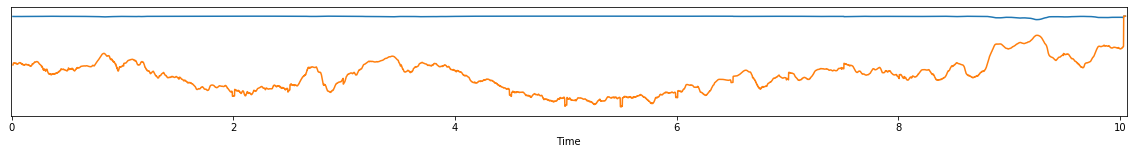

In [19]:
#print(speech_change_detection_prev)
speech_change_detection_prev

In [20]:
peak = Peak(alpha=0.2, min_duration=0.20, log_scale=True)

In [21]:
partition_prev = peak.apply(speech_change_detection_prev, dimension=1)

In [22]:
speaker_onset = partition_prev[-1].end - partition_prev[-1].start
print(speaker_onset)

0.8083437499999988


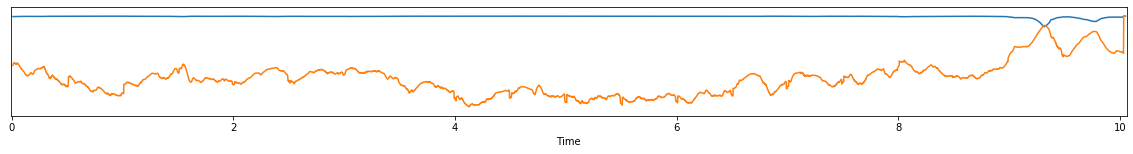

In [23]:
#print(speech_change_detection_next)
speech_change_detection_next

In [24]:
partition_next = peak.apply(speech_change_detection_next, dimension=1)

In [25]:
speaker_offset = partition_next[0].end - partition_next[0].start
print(speaker_offset)

9.318406249999999


# PyAudioAnalysis

In [61]:
from pyAudioAnalysis.audioSegmentation import speaker_diarization

In [66]:
speaker_diarization(STRETCHES_PATH +'/2016-01-01_0100_US_KNBC_Channel_4_News_bail_next189424.wav', n_speakers=-1)

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).